In [17]:
# 导入需要的包
import paddle
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import pickle
from paddle.vision.transforms import ToTensor
import paddle.nn as nn
import paddle.nn.functional as F
print("本教程基于Paddle的版本号为："+paddle.__version__)


本教程基于Paddle的版本号为：2.5.2


In [18]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 32, 32],                           #输入图片的shape
    "src_path":"data/cifar-10-python.tar.gz",       #原始数据集路径
    "target_path":"cifar-10-batches-py",        #要解压的路径 
    "num_epochs": 10,                                    #训练轮数
    "train_batch_size": 64,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    } 
}


In [19]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至/home/aistudio/目录下
    '''

    if(not os.path.isdir(target_path)):    
        import tarfile
        tar = tarfile.open(src_path,'r')
        tar.extractall(target_path)
        tar.close()
    else:
        print("文件已解压")


In [20]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
batch_size=train_parameters['train_batch_size']
image_size=train_parameters['input_size']
epoch_num=train_parameters['num_epochs']
lr=train_parameters['learning_strategy']['lr']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)


文件已解压


In [21]:
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("cifar-10-batches-py/data_batch_1").keys())
print(unpickle("cifar-10-batches-py/test_batch").keys())


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [22]:
'''
自定义数据集
'''
from paddle.io import Dataset
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, mode='train'):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        if mode == 'train':
            xs=[]
            ys=[]
            self.data = []
            self.label = []
            #批量读入数据
            for i in range(1,6):
                train_dict=unpickle("cifar-10-batches-py/data_batch_%d" % (i,))
                xs.append(train_dict[b'data'])
                ys.append(train_dict[b'labels'])
            #拼接数据
            Xtr = np.concatenate(xs)
            Ytr = np.concatenate(ys)
            #数据归一化处理
            for (x,y) in zip(Xtr,Ytr):  
                x= x.flatten().astype('float32')/255.0
                x= x.reshape(image_size)
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
        else:
            self.data = []
            self.label = []
            #读入数据
            test_dict=unpickle("cifar-10-batches-py/test_batch")
            X=test_dict[b'data']
            Y=test_dict[b'labels']
            for (x,y) in zip(X,Y):  
                #数据归一化处理
                x= x.flatten().astype('float32')/255.0
                x= x.reshape(image_size)
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        #返回单一数据和标签
        data = self.data[index]
        label = self.label[index]
        #注：返回标签数据时必须是int64
        return data, np.array(label, dtype='int64')
    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        #返回数据总数
        return len(self.data)

# 测试定义的数据集
train_dataset = MyDataset(mode='train')
eval_dataset = MyDataset(mode='val')
print('=============train_dataset =============')
#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())
print('=============eval_dataset =============')
#输出数据集的形状和标签
for data, label in eval_dataset:
    print(data.shape, label)
    break
#输出数据集的长度
print(eval_dataset.__len__())


=============train_dataset =============
(3, 32, 32) 9
50000
=============eval_dataset =============
(3, 32, 32) 3
10000


In [23]:
print('飞桨内置网络：', paddle.vision.models.__all__)
# 飞桨内置网络： ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'VGG', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 'MobileNetV1', 'mobilenet_v1', 'MobileNetV2', 'mobilenet_v2', 'LeNet']


飞桨内置网络： ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext50_64x4d', 'resnext101_32x4d', 'resnext101_64x4d', 'resnext152_32x4d', 'resnext152_64x4d', 'wide_resnet50_2', 'wide_resnet101_2', 'VGG', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 'MobileNetV1', 'mobilenet_v1', 'MobileNetV2', 'mobilenet_v2', 'MobileNetV3Small', 'MobileNetV3Large', 'mobilenet_v3_small', 'mobilenet_v3_large', 'LeNet', 'DenseNet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenet264', 'AlexNet', 'alexnet', 'InceptionV3', 'inception_v3', 'SqueezeNet', 'squeezenet1_0', 'squeezenet1_1', 'GoogLeNet', 'googlenet', 'ShuffleNetV2', 'shufflenet_v2_x0_25', 'shufflenet_v2_x0_33', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenet_v2_swish']


In [24]:
model = paddle.vision.models.resnet50()
save_path='resnet50'
paddle.summary(model,(1,3,32,32))


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
    Conv2D-180        [[1, 3, 32, 32]]     [1, 64, 16, 16]         9,408     
  BatchNorm2D-180    [[1, 64, 16, 16]]     [1, 64, 16, 16]          256      
      ReLU-61        [[1, 64, 16, 16]]     [1, 64, 16, 16]           0       
    MaxPool2D-5      [[1, 64, 16, 16]]      [1, 64, 8, 8]            0       
    Conv2D-182        [[1, 64, 8, 8]]       [1, 64, 8, 8]          4,096     
  BatchNorm2D-182     [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
      ReLU-62         [[1, 256, 8, 8]]      [1, 256, 8, 8]           0       
    Conv2D-183        [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
  BatchNorm2D-183     [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
    Conv2D-184        [[1, 64, 8, 8]]       [1, 256, 8, 8]        16,384     
  BatchNorm2D-184     [[1, 256, 8, 8]]      [1, 256, 8, 8]    

{'total_params': 25610152, 'trainable_params': 25557032}

In [25]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

start training ... 


c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


train_pass:0,batch_id:100,train_loss:[2.501315],train_acc:[0.265625]
train_pass:0,batch_id:200,train_loss:[1.8755891],train_acc:[0.390625]
train_pass:0,batch_id:300,train_loss:[1.8512349],train_acc:[0.390625]
train_pass:0,batch_id:400,train_loss:[1.5149212],train_acc:[0.5625]
train_pass:0,batch_id:500,train_loss:[1.3831801],train_acc:[0.4375]
train_pass:0,batch_id:600,train_loss:[1.3920425],train_acc:[0.5625]
train_pass:0,batch_id:700,train_loss:[1.6136296],train_acc:[0.453125]
train_pass:1,batch_id:100,train_loss:[1.693956],train_acc:[0.421875]
train_pass:1,batch_id:200,train_loss:[1.6647962],train_acc:[0.484375]
train_pass:1,batch_id:300,train_loss:[1.9912614],train_acc:[0.296875]
train_pass:1,batch_id:400,train_loss:[1.9094788],train_acc:[0.421875]
train_pass:1,batch_id:500,train_loss:[1.5851829],train_acc:[0.4375]
train_pass:1,batch_id:600,train_loss:[1.690707],train_acc:[0.4375]
train_pass:1,batch_id:700,train_loss:[2.6115477],train_acc:[0.328125]
train_pass:2,batch_id:100,train_l

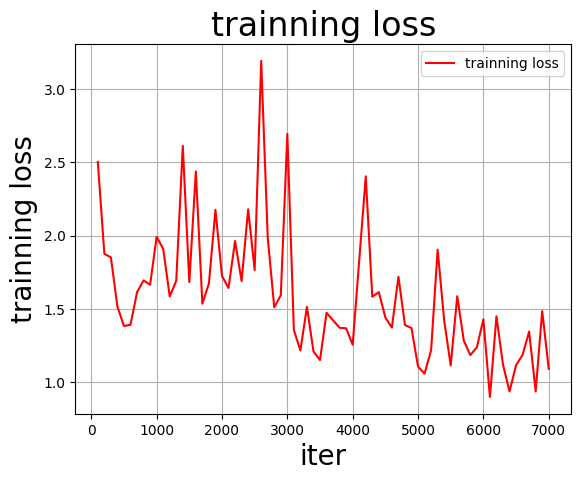

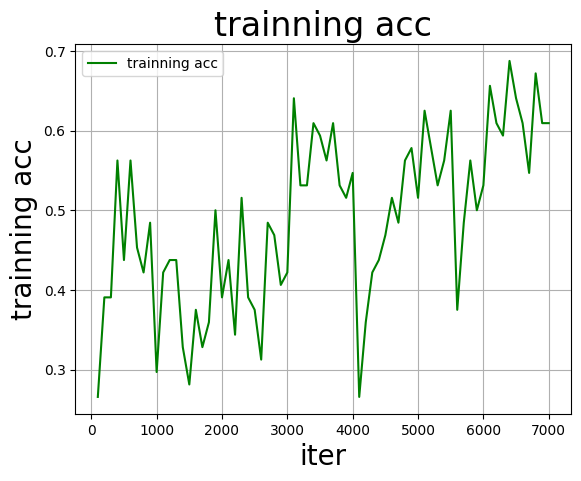

In [26]:
print('start training ... ')
Iters, total_loss, total_acc = [], [], []
Batch=0
# turn into training mode
model.train()

opt = paddle.optimizer.Adam(learning_rate=lr,
                            parameters=model.parameters())

train_loader = paddle.io.DataLoader(train_dataset,
                                    shuffle=True,
                                    batch_size=batch_size)

valid_loader = paddle.io.DataLoader(eval_dataset, batch_size=batch_size)

for epoch in range(epoch_num):
    for batch_id, data in enumerate(train_loader()):
        x_data = data[0]
        y_data = paddle.to_tensor(data[1])
        y_data = paddle.unsqueeze(y_data, 1)

        logits = model(x_data)
        loss = F.cross_entropy(logits, y_data)
        acc = paddle.metric.accuracy(logits,y_data)#计算精度
        if batch_id!=0 and batch_id%100==0:
            Batch = Batch + 100 
            Iters.append(Batch)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(epoch,batch_id,loss.numpy(),acc.numpy()))
        loss.backward()
        opt.step()
        opt.clear_grad() #opt.clear_grad()来重置梯度

paddle.save(model.state_dict(),save_path)#保存模型
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")


In [27]:
# 图片预处理
def load_image(file):
        '''
        预测图片预处理
        '''
        #打开图片
        im = Image.open(file)
        im = im.convert('RGB') 
        im=im
        # print(im.size)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        print('im_shape的维度：',im.shape)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im


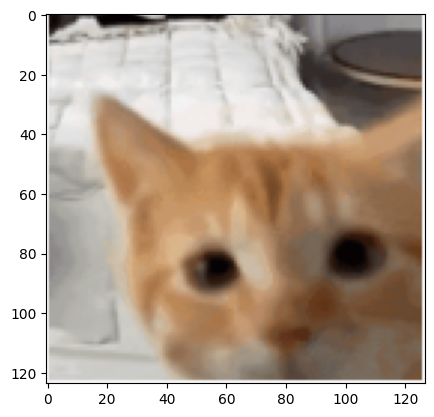

im_shape的维度： (32, 32, 3)
im_shape的维度： (1, 3, 32, 32)
预测为: dog


C:\Users\12631\AppData\Local\Temp\ipykernel_34048\2214490238.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((32, 32), Image.ANTIALIAS)


In [28]:
'''
模型预测
'''
para_state_dict = paddle.load("resnet50")
model = paddle.vision.models.resnet50()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

#展示预测图片
infer_path='data/cat.png'
# infer_path='dog.png'
img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

#对预测图片进行预处理
infer_img = load_image(infer_path)

infer_img = infer_img.reshape(3,32,32)

#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]

data = infer_img
dy_x_data = np.array(data).astype('float32')
dy_x_data=dy_x_data[np.newaxis,:, : ,:]
img = paddle.to_tensor (dy_x_data)
out = model(img)
lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
print("图片预测标签为:",label_list[lab])
